In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 16 14:26:49 2025

@author: yuhanyao
"""
%matplotlib inline
import pickle
import numpy as np
from scipy.interpolate import interp1d

import astropy.io.ascii as asci
import astropy.constants as const

import matplotlib
import matplotlib.pyplot as plt
fs= 10
matplotlib.rcParams['font.size']=fs
ms = 6
matplotlib.rcParams['lines.markersize']=ms

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
from scipy.interpolate import CubicSpline

In [49]:
golden_ratio = 1.618

fig_width = 6
fig_height = fig_width/golden_ratio

In [2]:
mags = [0., 25.5, 26.8, 27.6, 28.1]
labels = [1, 7, 40, 100]

In [ ]:
lamb_obs_um = 1 
peakmag = 25.6
peakmag_jetted = 25.4
verbose = False
lamb_obs_cm = lamb_obs_um/1e+4

In [3]:
def Planck(nu=None, T=None):
    """
    >> I = Planck(nu=1e14, T=1e4)

    return black body intensity (power per unit area per solid angle per frequency)
    """
    h = const.h.cgs.value
    c = const.c.cgs.value
    k_B = const.k_B.cgs.value
    x = np.exp(h*nu/(k_B*T))
    x = np.array(x)
    return 2*h/c**2 * nu**3 / (x-1)


def cc_bol(T, nu):
    """
    Color correction for blackbody spectrum
    (factor to multiply) from bolometric luminosity to nuLnu 
    
    note that nu is the frequency in TDE's rest-frame
    
    nuLnu / L_bol = nu pi B_nu(T) / (sigmaT^4)
    """
    return Planck(nu, T)*nu * np.pi /  (const.sigma_sb.cgs.value * T**4)


In [4]:
def get_jetted_tde_lum(t=4, nu_rest = np.logspace(14, 15.5), verbose = False):
    """
    t: rest-frame days 
    nu_rest: the observing band frequency in the TDE's rest frame
    """
    nu0 = 1e+15 # a reference frequency in the TDE's rest frame
    
    ### power-law component
    tpeak_pl = 0.03 # in days
    beta_rise = 3.62 
    beta_decay = -0.46
    Lnu0_peak_pl = 10**30.56 # erg/s/Hz
    
    L1_nu_ref = 0
    if t <= tpeak_pl:
        L1_nu_ref = Lnu0_peak_pl * 10**(beta_rise * (t - tpeak_pl))
    else:
        L1_nu_ref = Lnu0_peak_pl * 10**(beta_decay * (t - tpeak_pl))
        
    alpha = -1.11
    L1_nu = L1_nu_ref * (nu_rest/nu0)**alpha
    nuLnu_comp1 = nu_rest * L1_nu
        
    ### blackbody component
    L0_peak_bb = 10**44.41 
    tpeak_bb = 5.84 # in days
    sigma_bb = 10**1.06
    tau_bb = 10**1.53
    T0 = 10**4.57
    
    L2_ref = 0 # nuLnu at nu0
    if t<= tpeak_bb:
        L2_ref = L0_peak_bb * np.exp(-1*(t - tpeak_bb)**2 / (2*sigma_bb**2))
    else:
        L2_ref = L0_peak_bb * np.exp(-1*(t - tpeak_bb) / tau_bb)
    
    _nuLnu = nu_rest * Planck(nu=nu_rest, T=T0)
    _nuLnu_0 = nu0*Planck(nu=nu0, T=T0)
    
    nuLnu_comp2 = L2_ref * _nuLnu / _nuLnu_0
        
    
    nuLnu = nuLnu_comp1 + nuLnu_comp2
    
    if verbose:
        plt.figure()
        plt.plot(nu_rest, nuLnu_comp1)
        plt.plot(nu_rest, nuLnu_comp2)
        plt.plot(nu_rest, nuLnu)
        plt.semilogx()
        plt.semilogy()
        plt.xlabel("nu_rest (Hz)")
        plt.xlabel("nuLnu (erg/s)")
    return nuLnu

In [21]:
def get_scatter(ax, t, ymod, c):
    spl = CubicSpline(t, ymod)
    
    for j, nstack in enumerate(labels):
        
        step = 10 * nstack
        tsample = step/4. + np.arange(0, int(1000./step)) * step
        interp = spl(tsample)
        mask = (interp > mags[j]) & (interp < mags[j+1])
        ax.scatter(tsample[mask], spl(tsample)[mask], color=c)

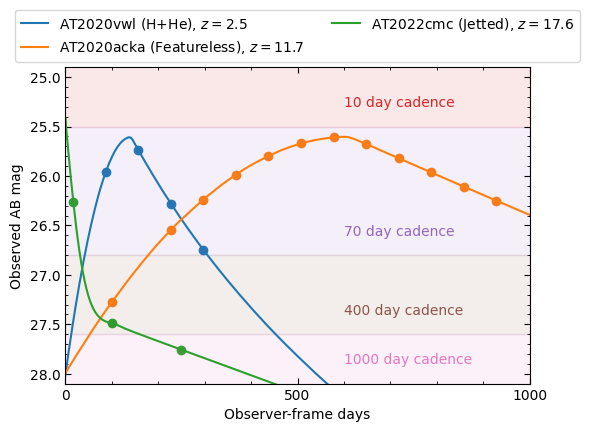

In [199]:
zs = np.hstack([np.linspace(0.01, 4.99, 499),
                np.linspace(5, 20, 151)])
D_pcs = cosmo.luminosity_distance([zs])[0].value * 1e+6 
D_cms = D_pcs * const.pc.cgs.value

D_10pc = 10 * const.pc.cgs.value
nu_obs = const.c.cgs.value / lamb_obs_cm
tb = asci.read("./data/representative_tde.dat")[1:]


zmaxs = np.zeros(len(tb))
for i in range(len(tb)):
    ztfname = tb["ztfname"][i]
    #z = tb["z"][i]
    lgTbb = tb["lgTbb"][i]
    lgRbb = tb["lgRbb"][i]
    lgLbb = tb["lgLbb"][i]
    
    mpeaks_obs = np.zeros(len(zs))
    for j in range(len(zs)):
        z = zs[j]
        nu_rest = nu_obs * (1+z)
        nuLnu_rest = 10**lgLbb * cc_bol(10**lgTbb, nu=nu_rest)
        Lnu_obs = nuLnu_rest / nu_obs
        
        mpeaks_obs[j] = -2.5 * np.log10(Lnu_obs / (4 * np.pi* D_cms[j]**2)/3631e-23)
    
    if verbose:
        plt.figure()
        ax = plt.subplot(111)
        ax.plot(zs, mpeaks_obs)
        ax.semilogy()
        ax.semilogx()
        ax.plot([zs[0], zs[-1]], [peakmag, peakmag])
        ax.set_xlabel("z")
        ax.set_ylabel("apparant mag")
        ax.set_title(ztfname)
        
    # get the highest redshift out to which this transient can be detected by Roman
    myfunc = interp1d(mpeaks_obs, zs)
    zmaxs[i] = myfunc(peakmag)

# calculate the maximum distance of a jetted TDE
mpeaks_obs = np.zeros(len(zs))
ts_rest = np.hstack([np.linspace(0.01, 0.09, 9), np.linspace(1, 6, 51)])
for j in range(len(zs)):
    z = zs[j]
    nu_rest = nu_obs * (1+z)
    nuLnus = np.zeros(len(ts_rest))
    for k in range(len(ts_rest)):
        nuLnus[k] = get_jetted_tde_lum(ts_rest[k], nu_rest)
    
    mags_obs =  -2.5 * np.log10(nuLnus / nu_obs / (4 * np.pi * D_cms[j]**2) / (3631e-23))
    #plt.plot(ts_rest, mags_obs)
    mpeaks_obs[j] = min(mags_obs)
if verbose:
    plt.figure()
    ax = plt.subplot(111)
    ax.plot(zs, mpeaks_obs)
    ax.semilogy()
    ax.semilogx()
    ax.plot([zs[0], zs[-1]], [peakmag, peakmag])
    ax.set_xlabel("z")
    ax.set_ylabel("apparant mag")
    ax.set_title("AT2022cmc")
myfunc = interp1d(mpeaks_obs, zs)
zmax_jetted = myfunc(peakmag_jetted)


plt.figure(figsize = (fig_width, fig_height*1.2))
ax = plt.subplot(111)

for i in range(len(tb)):
    ztfname = tb["ztfname"][i]
    atname = tb["atname"][i]
    z = zmaxs[i]
    D_cm = cosmo.luminosity_distance([z])[0].value * 1e+6  * const.pc.cgs.value
    
    tpeak_mjd_guess = tb['tmax_visual'][i]
    fit_name = tb["fit_name"][i]
    fname = './data/mcmc_result/%s_%s.pickle'%(ztfname, fit_name)
    #print (fname)
    
    mcmc_dt = pickle.load(open(fname,'rb'),encoding='latin1')[0]
    tpeak_mjd =  tpeak_mjd_guess + mcmc_dt["tpeak"][0]*(1+z)
    
    lgT = mcmc_dt["T"][0]
    T1 = 10**lgT
    
    lcs = mcmc_dt["lc"]
    tmod = lcs["time"]-mcmc_dt["tpeak"][0]
    Lmod_ = lcs["L_kc"]
    Lmod = np.percentile(Lmod_, [50], axis=0)[0] # This is nuLnu rest-frame g-band
    
    nug = 6.3e+14
    Lbbs = Lmod / cc_bol(T1, nu=nug) # bolometric blackbody luminosity
    
    nu_rest = nu_obs * (1+z)
    nuLnu_rest = Lbbs * cc_bol(T1, nu=nu_rest)
    
    fratio = nuLnu_rest / nu_obs / (4 * np.pi * D_cm**2) / (3631e-23)
    ymod =  -2.5 * np.log10(fratio)
    
    
    ix = ymod < 30
    tmod = tmod[ix]
    ymod = ymod[ix]
    
    # time dilation
    t_obs = tmod * (1+z)

    mask = ymod<28.0
    offset = t_obs[mask][0]
    
    if atname == "2020vdq":
        label = "subluminous"
        linestyle = "-."
    elif atname == "2020vwl":
        label = f"AT{atname} (H+He)"
        linestyle = "-"
    elif atname == "2020acka":
        label = f"AT{atname} (Featureless)"
        linestyle = ":"
    linestyle="-"
    label += ", "+r"$z = %.1f$"%(z)

    t = t_obs + 1. - offset
    
    ax.plot(t, ymod, label = label, linestyle = linestyle)

    get_scatter(ax, t, ymod, c=f"C{i}")

nu_rest_jetted = nu_obs * (1+zmax_jetted)
D_cm_jetted = cosmo.luminosity_distance([zmax_jetted])[0].value * 1e+6  * const.pc.cgs.value
ts_rest_jetted = np.hstack([np.linspace(0.001, 0.040, 41), np.linspace(0.05, 0.1, 6), 
                            np.linspace(0.1, 5, 50), np.linspace(5, 50, 46)])
nuLnus_jetted = np.zeros(len(ts_rest_jetted))
for k in range(len(ts_rest_jetted)):
    nuLnus_jetted[k] = get_jetted_tde_lum(ts_rest_jetted[k], nu_rest_jetted)
mags_obs_jetted =  -2.5 * np.log10(nuLnus_jetted / nu_obs / (4 * np.pi * D_cm_jetted**2) / (3631e-23))
ind_peak = np.argsort(mags_obs_jetted)[0]
ts_obs_jetted = (ts_rest_jetted - ts_rest_jetted[ind_peak])*(1+zmax_jetted)
ax.plot(ts_obs_jetted, mags_obs_jetted, label = "AT2022cmc (Jetted), "+r"$z = %.1f$"%zmax_jetted,
        linestyle = "-")

mask = np.diff(ts_obs_jetted) > 0.0
get_scatter(ax, ts_obs_jetted[1:][mask], mags_obs_jetted[1:][mask], c="C2")

for i, m_low in enumerate(mags[:-1]):
    m_high = mags[i+1]
    ax.fill_between(x=[-1000, 1000],y1=[m_low, m_low], y2=[m_high, m_high], alpha=0.1, color=f"C{i+3}")
    ax.annotate(f"{10*labels[i]} day cadence", xy=(600, m_high-0.2), color=f"C{i+3}")
ax.set_ylim(mags[-1], peakmag_jetted - 0.5)

ax.legend(bbox_to_anchor=(0.5,1.1), ncols=2, loc='center')
ax.tick_params(which = 'major', length = 4, top=True, direction = "in", 
                     right = True)
ax.tick_params(which = 'minor', length = 2, top=True, direction = "in", 
                     right = True)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
ax.xaxis.set_major_locator(plt.MultipleLocator(500))
ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
ax.set_xlabel("Observer-frame days")
ax.set_ylabel("Observed AB mag")
ax.set_label("Roman TDE light curve")
ax.set_xlim(left=0., right=1000.)
# ax.set_xscale("log")
plt.tight_layout()
plt.savefig("./figs/tde_panel_1.pdf", dpi=300.)

In [6]:
tb = asci.read("./data/representative_tde.dat")
tb

ztfname,atname,nickname,ebv_SF11,ebv_SF11_unc,ra_ztf,dec_ztf,ztf_1st_alert_mjd,gpeak,rpeak,z,tmax_visual,cat,sptype,ID,gpeak_p1,rpeak_p1,rise_type,decay_type,tabname,cind,marker,sigma,sigma_unc,Tspan,mass_SS,mass_SS-,mass_SS+,u-r.0_SS,u-r.0_SS-,u-r.0_SS+,tau_SS,tau_SS-,tau_SS+,tage_SS,tage_SS-,tage_SS+,logzsol_SS,logzsol_SS-,logzsol_SS+,dust2_SS,dust2_SS-,dust2_SS+,Ebv_host_SS,Ebv_host_SS+,Ebv_host_SS-,lgMbh,lgMbh_unc,lgMbh_SS,lgMbh_SS-,lgMbh_SS+,lgMbh_adopt,lgMbh_adopt_unc,weightr,weightg,weightb,r50,Dmax_t_Gpc,Dmax_t_Mpc,zmax_t,Dmax_t_kpc,D_Mpc,lgLg,Mg,lgTbb,lgLbb,lgRbb,t1/2,t1/2-,t1/2+,t1/2_rise,t1/2_rise-,t1/2_rise+,t1/2_decay,t1/2_decay-,t1/2_decay+,te_rise,te_rise-,te_rise+,te_decay,te_decay-,te_decay+,wv_g_obs,wv_r_obs,tpeak_mjd,f_loss,fit_name,cg,cr,nu_g_obs,nu_r_obs,lambda_Edd,lambda_Edd_unc
str12,str8,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str15,float64,float64,float64,float64,float64,str6,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64
ZTF20acaazkt,2020vdq,--,0.0153,0.0004,152.2227354,42.7167535,59109.50626160018,19.182310104370117,18.655216217041016,0.045,59105.0,ztfi,Unknown,16.0,--,--,1.0,2.0,tab20b,1.0,^,43.560137452700786,3.065269511957542,1.9138755980861246,9.250334201406348,0.1085919278304992,0.07359990351648271,1.6924598466385792,0.06856986173968393,0.08674216949704672,1.339058915365339,1.0836290327787854,0.8077430629968088,8.18462034148573,3.706212306845665,2.946307121336206,-1.0954914466050472,0.5342754875811642,0.2978052621067169,0.2239169029696085,0.13541820463140494,0.13422663618429467,0.060042902870369105,0.035992623924973835,0.03631214079745822,5.589051733697088,0.37488988917577815,5.127658397767966,0.5651302131119025,0.5479887217343286,5.589051733697088,0.37488988917577815,9.268593645573687e-05,0.09847006190633269,0.9014372521572119,1.254,0.22751627762167015,227.51627762167016,0.05113401924927838,227516.27762167016,199.33832485841265,42.61769754445942,-17.951049479066427,4.155110828443039,42.99152027573807,14.7591276806527,35.262866491574144,2.3684493481390376,2.243037701324674,11.893830037167202,1.33681162020995,1.6611677099746576,23.324809803471783,1.7170824613730709,1.516811898510941,14.297614451399479,1.6080622583793165,1.9983958372495643,36.21072671735878,2.222325090009228,2.1132004615241513,4758.431995324809,6375.382370116711,59113.094708887555,0.21,1yr_pl_Tfix,1.0709569838539155,0.6416574620274546,630023626048555.6,470234474727688.9,-0.6944136675995196,0.37488988917577815
ZTF20achpcvt,2020vwl,Mando,0.0416,0.0008,232.6575481,26.9824432,59130.09718749998,17.60982322692871,17.662553787231445,0.0325,59170.0,ztfii,TDE-H+He,17.0,17.60982322692871,17.662553787231445,1.0,4.0,tab20b,0.0,o,48.492345513717254,2.00428378214394,0.9685230024213075,9.886777526979229,0.0799042129347427,0.07773574673011474,2.0768134943030407,0.03952935395468149,0.03354985033813218,0.36311605405452846,0.21216842828452573,0.41786529972202074,8.81227901597625,2.160074661499676,2.1832176044795784,-0.8362666964203438,0.28176554489453176,0.16939615232890015,0.17050266795194036,0.09606804157039375,0.1497737291047802,0.04571997466563142,0.04016154810068922,0.0257604674433204,5.793275767919205,0.35197144662135743,6.228705351009049,0.34653380858174426,0.34505448375182757,5.793275767919205,0.35197144662135743,0.4868252094570906,0.5131746812960685,1.0924684260412803e-07,2.368,0.5153275455822932,515.3275455822932,0.11112875432317451,515327.5455822932,142.65499131311074,43.1291

In [136]:
def get_ndet(i, z):

    ztfname = tb["ztfname"][i]
    atname = tb["atname"][i]
    D_cm = cosmo.luminosity_distance([z])[0].value * 1e+6  * const.pc.cgs.value
    
    tpeak_mjd_guess = tb['tmax_visual'][i]
    fit_name = tb["fit_name"][i]
    fname = './data/mcmc_result/%s_%s.pickle'%(ztfname, fit_name)
    #print (fname)
    
    mcmc_dt = pickle.load(open(fname,'rb'),encoding='latin1')[0]
    tpeak_mjd =  tpeak_mjd_guess + mcmc_dt["tpeak"][0]*(1+z)
    
    lgT = mcmc_dt["T"][0]
    T1 = 10**lgT
    
    lcs = mcmc_dt["lc"]
    tmod = lcs["time"]-mcmc_dt["tpeak"][0]
    Lmod_ = lcs["L_kc"]
    Lmod = np.percentile(Lmod_, [50], axis=0)[0] # This is nuLnu rest-frame g-band
    
    nug = 6.3e+14
    Lbbs = Lmod / cc_bol(T1, nu=nug) # bolometric blackbody luminosity
    
    nu_rest = nu_obs * (1+z)
    nuLnu_rest = Lbbs * cc_bol(T1, nu=nu_rest)
    
    fratio = nuLnu_rest / nu_obs / (4 * np.pi * D_cm**2) / (3631e-23)
    ymod =  -2.5 * np.log10(fratio)    
    
    ix = ymod < 30
    tmod = tmod[ix]
    ymod = ymod[ix]

    # time dilation
    t_obs = tmod * (1+z)

    n_det = 0
    mask = (ymod<28.0)

    if mask.sum() > 0:

        offset = t_obs[mask][0]
        
        t = t_obs + 1. - offset

        mask = (t_obs > 0.) & (t_obs < 1000.)
        t, ymod = t[mask], ymod[mask]
    
        spl = CubicSpline(t, ymod)
        
        for j, nstack in enumerate(labels[:-2]):
            
            step = 10 * nstack
    
            n_det_sub = 0
            
            steps = np.linspace(0.0, step, 100)
    
            for k in steps:
            
                tsample = k + np.arange(0, int(1000./step)) * step
                interp = spl(tsample)
                mask = (interp > mags[j]) & (interp < mags[j+1])
    
                n_det_sub += float(mask.sum())/len(steps)
    
            n_det += n_det_sub

    return n_det


get_ndet(0, 2.1)

5.339999999999996

In [178]:
z_range = np.linspace(0.5, 15., 50)
n_dets = [get_ndet(1, x) for x in z_range]

Text(0.5, 0, 'Redshift')

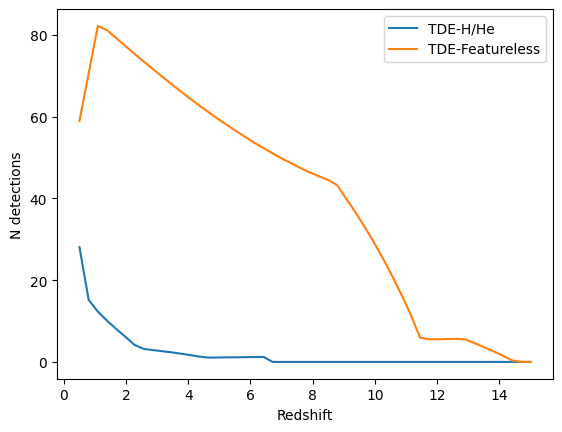

In [185]:
for i in range(2):
    n_dets = [get_ndet(i, x) for x in z_range]
    plt.plot(z_range, n_dets, label=["TDE-H/He", "TDE-Featureless"][i])

# plt.yscale("log")
plt.ylabel("N detections")
plt.legend()
plt.xlabel("Redshift")

In [131]:
def get_app_mag(i, z):

    ztfname = tb["ztfname"][i]
    atname = tb["atname"][i]
    D_cm = cosmo.luminosity_distance([z])[0].value * 1e+6  * const.pc.cgs.value
    
    tpeak_mjd_guess = tb['tmax_visual'][i]
    fit_name = tb["fit_name"][i]
    fname = './data/mcmc_result/%s_%s.pickle'%(ztfname, fit_name)
    #print (fname)
    
    mcmc_dt = pickle.load(open(fname,'rb'),encoding='latin1')[0]
    tpeak_mjd =  tpeak_mjd_guess + mcmc_dt["tpeak"][0]*(1+z)
    
    lgT = mcmc_dt["T"][0]
    T1 = 10**lgT
    
    lcs = mcmc_dt["lc"]
    tmod = lcs["time"]-mcmc_dt["tpeak"][0]
    Lmod_ = lcs["L_kc"]
    Lmod = np.percentile(Lmod_, [50], axis=0)[0] # This is nuLnu rest-frame g-band
    
    nug = 6.3e+14
    Lbbs = Lmod / cc_bol(T1, nu=nug) # bolometric blackbody luminosity
    
    nu_rest = nu_obs * (1+z)
    nuLnu_rest = Lbbs * cc_bol(T1, nu=nu_rest)
    
    fratio = nuLnu_rest / nu_obs / (4 * np.pi * D_cm**2) / (3631e-23)
    ymod =  -2.5 * np.log10(fratio) 

    return ymod.min()

get_app_mag(0, 2.1)

np.float64(25.300230192399408)

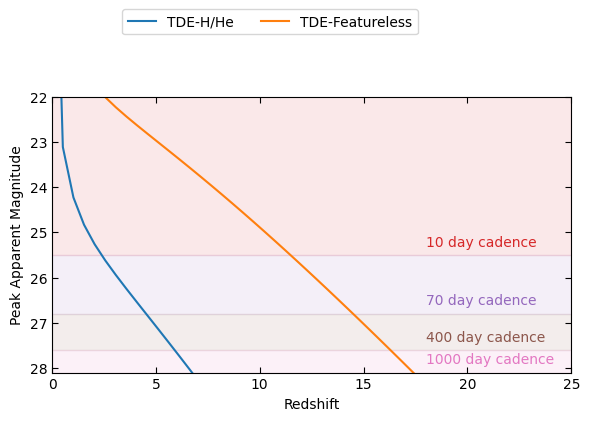

In [175]:
z_range = np.linspace(0.01, 25., 50)

plt.figure(figsize = (fig_width, fig_height*1.2))
ax = plt.subplot(111)

for i in range(2):
    n_dets = [get_app_mag(i, x) for x in z_range]
    plt.plot(z_range, n_dets, label=["TDE-H/He", "TDE-Featureless"][i])

# plt.ylabel("Peak Apparent Magnitude")
for i, m_low in enumerate(mags[:-1]):
    m_high = mags[i+1]
    ax.fill_between(x=[0.0, z_range[-1]],y1=[m_low, m_low], y2=[m_high, m_high], alpha=0.1, color=f"C{i+3}")
    ax.annotate(f"{10*labels[i]} day cadence", xy=(18., m_high-0.2), color=f"C{i+3}")
ax.set_ylim(mags[-1], 22.)

ax.legend(bbox_to_anchor=(0.42,1.2), ncols=2)
ax.tick_params(which = 'major', length = 4, top=True, direction = "in", 
                     right = True)
ax.tick_params(which = 'minor', length = 2, top=True, direction = "in", 
                     right = True)
# ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
# ax.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
# ax.xaxis.set_major_locator(plt.MultipleLocator(500))
# ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
ax.set_xlabel("Redshift")
ax.set_ylabel("Peak Apparent Magnitude")
ax.set_label("Roman TDE light curve")
ax.set_xlim(left=0.0, right=z_range[-1])
# ax.set_xscale("log")
plt.tight_layout()
plt.savefig("./figs/tde_panel_2.pdf", dpi=300.)

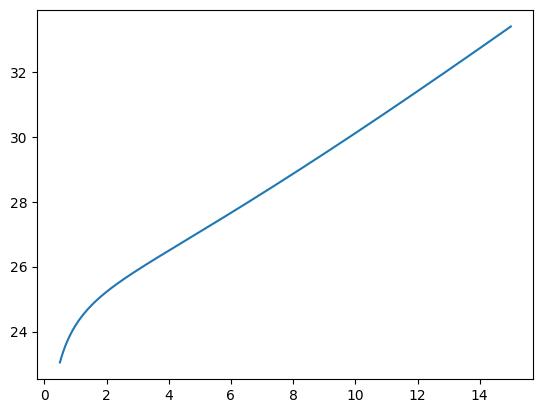

In [135]:
plt.plot(z_range, n_dets)